In [1]:
%matplotlib inline
import random
import time
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager, Process, Value, Lock
from multiprocessing.dummy import Pool as ThreadPool

This notebook was tested on a Mac. Changes may be required to run this code in a Windows machine. 

In these examples I am hardcoding the number of cores to use (`NUM_PROCESSES = 4`). The `multiprocessing` module will try and use all available cores, so you shouldn't need to hardcode the number of processes unless you want to manage your resources. In my experience, at least in Windows machines, I've noticed that is better to hardcode the number of processes as number of available cores - 1. Otherwise, the operating system starts feeling laggy and unresponsive. 

## Estimate the value of pi using the Monte Carlo method

We generate multiple random values. The proportion of random values within a unit circle (x^2 + y^2 <= 1) with respect to the total amoung of generated random values is our approximation of pi. 

This is an ideal first problem because the workload can be evenly split across a number of processes. 

In [2]:
def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    nbr_trials_in_quarter_unit_circle = 0
    
    for step in range(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle
    return nbr_trials_in_quarter_unit_circle

This version uses a pool of processes. The time is estimated after creating the pool, because spawning processes (as opposed to spawning threads) has some overhead. 

In [3]:
nbr_samples_in_total = 1e8

times_proc = []

for num_processes in range(1,9):
    print('Number of processes: ' + str(num_processes))
    pool = Pool(processes = num_processes)
    nbr_samples_per_worker = nbr_samples_in_total / num_processes
    print('Making {} samples per worker'.format(nbr_samples_per_worker))
    nbr_trials_per_process = [nbr_samples_per_worker] * num_processes

    t1 = time.time()
    nbr_in_unit_circles = pool.map(estimate_nbr_points_in_quarter_circle, nbr_trials_per_process)
    # We multiply by 4 because we are producing sampels only on one quarter of the unit circle
    pi_estimate = sum(nbr_in_unit_circles) * 4 / nbr_samples_in_total
    print('Estimated pi ' + str(pi_estimate))
    delta = time.time() - t1
    print('Delta: ' + str(delta))
    print('-----------------')
    
    pool.close()
    
    times_proc.append(delta)

Number of processes: 1
Making 100000000.0 samples per worker
Estimated pi 3.14180196
Delta: 55.693289041519165
-----------------
Number of processes: 2
Making 50000000.0 samples per worker
Estimated pi 3.1414536
Delta: 28.64632511138916
-----------------
Number of processes: 3
Making 33333333.333333332 samples per worker
Estimated pi 3.14151632
Delta: 21.720614194869995
-----------------
Number of processes: 4
Making 25000000.0 samples per worker
Estimated pi 3.14148472
Delta: 18.48305892944336
-----------------
Number of processes: 5
Making 20000000.0 samples per worker
Estimated pi 3.14174572
Delta: 14.925731182098389
-----------------
Number of processes: 6
Making 16666666.666666666 samples per worker
Estimated pi 3.1417052
Delta: 13.017522096633911
-----------------
Number of processes: 7
Making 14285714.285714285 samples per worker
Estimated pi 3.14125252
Delta: 13.323940753936768
-----------------
Number of processes: 8
Making 12500000.0 samples per worker
Estimated pi 3.14170812

This version is based on threads. The problem with threads is that due to Python's GIL contraint (Global Interpreter Lock) only one thread can run at a time. As a consequence of this, adding more threads actually slows down the process (due to the overhead of switching between threads).

In [4]:
nbr_samples_in_total = 1e8

times_thread = []

for num_processes in range(1,9):
    print('Number of processes: ' + str(num_processes))
    pool = ThreadPool(processes = num_processes)
    nbr_samples_per_worker = nbr_samples_in_total / num_processes
    print('Making {} samples per worker'.format(nbr_samples_per_worker))
    nbr_trials_per_process = [nbr_samples_per_worker] * num_processes

    t1 = time.time()
    nbr_in_unit_circles = pool.map(estimate_nbr_points_in_quarter_circle, nbr_trials_per_process)
    # We multiply by 4 because we are producing sampels only on one quarter of the unit circle
    pi_estimate = sum(nbr_in_unit_circles) * 4 / nbr_samples_in_total
    print('Estimated pi ' + str(pi_estimate))
    delta = time.time() - t1
    print('Delta: ' + str(delta))
    print('-----------------')
    
    pool.close()
    
    times_thread.append(delta)

Number of processes: 1
Making 100000000.0 samples per worker
Estimated pi 3.14183296
Delta: 56.62530469894409
-----------------
Number of processes: 2
Making 50000000.0 samples per worker
Estimated pi 3.14174132
Delta: 55.93664193153381
-----------------
Number of processes: 3
Making 33333333.333333332 samples per worker
Estimated pi 3.14150508
Delta: 56.60968613624573
-----------------
Number of processes: 4
Making 25000000.0 samples per worker
Estimated pi 3.14167376
Delta: 56.78120398521423
-----------------
Number of processes: 5
Making 20000000.0 samples per worker
Estimated pi 3.141206
Delta: 56.02603793144226
-----------------
Number of processes: 6
Making 16666666.666666666 samples per worker
Estimated pi 3.14152972
Delta: 56.230332136154175
-----------------
Number of processes: 7
Making 14285714.285714285 samples per worker
Estimated pi 3.14139084
Delta: 56.66766285896301
-----------------
Number of processes: 8
Making 12500000.0 samples per worker
Estimated pi 3.14159416
Del

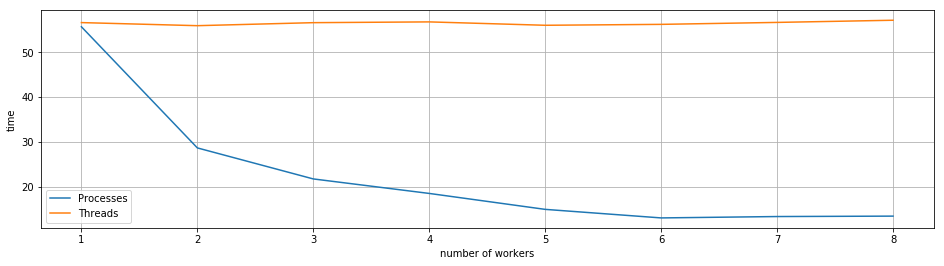

In [5]:
fig, ax = plt.subplots()
ax.plot(range(1, 9), times_proc)
ax.plot(range(1, 9), times_thread)
ax.set_xlabel('number of workers')
ax.set_ylabel('time')
ax.grid(True)
ax.legend(['Processes', 'Threads'])
fig.set_figwidth(16)

## Estimate the value of pi using the Monte Carlo method (numpy version)

In this version we need to explicitely set numpy's random seed for each forked process (not for threads). Otherwise, all the workers wil generate exactly the same sequence of random numbers. This is because all forks share the same shared state. This is not the case with the `random` module, which was used above, because this is dealt with by the `multiprocessing` module. 

In [6]:
def estimate_nbr_points_in_quarter_circle(nbr_samples):
    np.random.seed()
    
    xs = np.random.uniform(0, 1, nbr_samples)
    ys = np.random.uniform(0, 1, nbr_samples)
    estimate_inside_quarter_unit_circle = (xs * xs + ys * ys) <= 1
    nbr_trials_in_quarter_unit_circle = np.sum(estimate_inside_quarter_unit_circle)
    return nbr_trials_in_quarter_unit_circle

In [7]:
nbr_samples_in_total = 1e8

times_proc = []

for num_processes in range(1,9):
    print('Number of processes: ' + str(num_processes))
    pool = Pool(processes = num_processes)
    nbr_samples_per_worker = int(nbr_samples_in_total / num_processes)
    print('Making {} samples per worker'.format(nbr_samples_per_worker))
    nbr_trials_per_process = [nbr_samples_per_worker] * num_processes

    t1 = time.time()
    nbr_in_unit_circles = pool.map(estimate_nbr_points_in_quarter_circle, nbr_trials_per_process)
    # We multiply by 4 because we are producing sampels only on one quarter of the unit circle
    pi_estimate = sum(nbr_in_unit_circles) * 4 / nbr_samples_in_total
    print('Estimated pi ' + str(pi_estimate))
    delta = time.time() - t1
    print('Delta: ' + str(delta))
    print('-----------------')
    
    pool.close()
    
    times_proc.append(delta)

Number of processes: 1
Making 100000000 samples per worker
Estimated pi 3.1417034
Delta: 4.008562803268433
-----------------
Number of processes: 2
Making 50000000 samples per worker
Estimated pi 3.1417234
Delta: 1.8612520694732666
-----------------
Number of processes: 3
Making 33333333 samples per worker
Estimated pi 3.14163152
Delta: 1.4414749145507812
-----------------
Number of processes: 4
Making 25000000 samples per worker
Estimated pi 3.14146844
Delta: 1.2310590744018555
-----------------
Number of processes: 5
Making 20000000 samples per worker
Estimated pi 3.14172112
Delta: 1.1236419677734375
-----------------
Number of processes: 6
Making 16666666 samples per worker
Estimated pi 3.14160956
Delta: 1.154047966003418
-----------------
Number of processes: 7
Making 14285714 samples per worker
Estimated pi 3.14164564
Delta: 1.0820579528808594
-----------------
Number of processes: 8
Making 12500000 samples per worker
Estimated pi 3.1416424
Delta: 1.0063738822937012
--------------

In [8]:
nbr_samples_in_total = 1e8

times_thread = []

for num_processes in range(1,9):
    print('Number of processes: ' + str(num_processes))
    pool = ThreadPool(processes = num_processes)
    nbr_samples_per_worker = int(nbr_samples_in_total / num_processes)
    print('Making {} samples per worker'.format(nbr_samples_per_worker))
    nbr_trials_per_process = [nbr_samples_per_worker] * num_processes

    t1 = time.time()
    nbr_in_unit_circles = pool.map(estimate_nbr_points_in_quarter_circle, nbr_trials_per_process)
    # We multiply by 4 because we are producing sampels only on one quarter of the unit circle
    pi_estimate = sum(nbr_in_unit_circles) * 4 / nbr_samples_in_total
    print('Estimated pi ' + str(pi_estimate))
    delta = time.time() - t1
    print('Delta: ' + str(delta))
    print('-----------------')
    
    pool.close()
    
    times_thread.append(delta)

Number of processes: 1
Making 100000000 samples per worker
Estimated pi 3.14149796
Delta: 3.197511911392212
-----------------
Number of processes: 2
Making 50000000 samples per worker
Estimated pi 3.14166328
Delta: 2.956697940826416
-----------------
Number of processes: 3
Making 33333333 samples per worker
Estimated pi 3.14157696
Delta: 2.914911985397339
-----------------
Number of processes: 4
Making 25000000 samples per worker
Estimated pi 3.14138796
Delta: 2.950700044631958
-----------------
Number of processes: 5
Making 20000000 samples per worker
Estimated pi 3.14139728
Delta: 2.981640100479126
-----------------
Number of processes: 6
Making 16666666 samples per worker
Estimated pi 3.1418138
Delta: 2.861567974090576
-----------------
Number of processes: 7
Making 14285714 samples per worker
Estimated pi 3.14151448
Delta: 2.5172529220581055
-----------------
Number of processes: 8
Making 12500000 samples per worker
Estimated pi 3.14150396
Delta: 2.5391342639923096
----------------

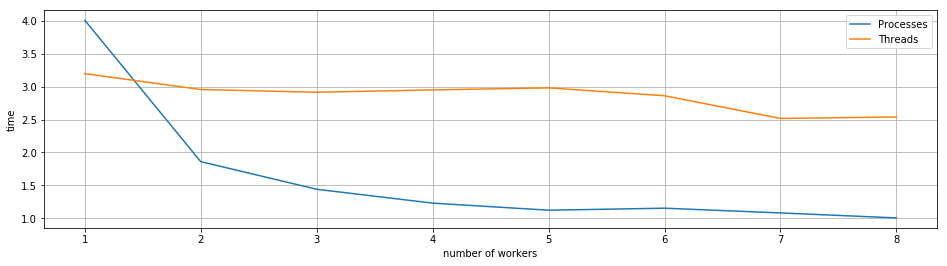

In [9]:
fig, ax = plt.subplots()
ax.plot(range(1, 9), times_proc)
ax.plot(range(1, 9), times_thread)
ax.set_xlabel('number of workers')
ax.set_ylabel('time')
ax.grid(True)
ax.legend(['Processes', 'Threads'])
fig.set_figwidth(16)

Obviously, this vectorised version of the code is much faster than the first version on this notebook based on pure Python. 

Adding more threads decreases the overall execution time. This is because numpy can achieve additional spped ups by operating outside the GIL. 

## Finding prime numbers

We test for prime numbers over a large number range. This is a different problem to pi value estimation because the workload depends on the location in the number range and each number's check has an unpredictable complexity. However, the problem is still embarrasingly parallel (we do not need to pass state information between processes).

The `multiprocessing` module, by default, divides the total number of items to compute by the number of processors. This may be the best approach if the computation of each item takes approximately the same amount of time. 

Strategies for efficiently use `multiprocessing` for embarrassingly parallel problems:

- Split your jobs into independent units of work
- If your workers take varying amounts of time, then consider randomizing the sequence of work
- Sorting your work queue so slowest jobs go first may help
- Use the default chunksize unless you have verified reasons to change it
- Align the number of jobs with the number of physical cpus

This is the function that we use to check whether a single number is primer or not:

In [10]:
def check_prime(n):
    if n % 2 == 0:
        return False
    from_i = 3
    to_i = math.sqrt(n) + 1
    for i in range(from_i, int(to_i), 2):
        if n % i == 0:
            return False
    return True

And we can use this function to check a list of numbers (the `numbers` parameter) using a pool of workers with a given `chunksize`, that is, how many numbers are assigned to each worker. This function returns the total time it took to perform the computation (the time used to create the pool of workers is not taken into account).

In [11]:
def check_primes(chunksize, numbers): 
    num_processes = 4

    pool = Pool(processes = num_processes)
    t1 = time.time()
    is_prime = pool.map(check_prime, numbers, chunksize)
    delta = time.time() - t1

    pool.close()   
    
    return delta

For instance:

In [12]:
def generate_numbers():
    for n in range(100000000, 100100000):
        yield n

In [13]:
check_primes(100, generate_numbers())

0.6261138916015625

We are going to try and compare some of the strategies enumerated above and compare execution times:

In [14]:
# Using chunksizes that are multiplo of the number of processes
chunksizes = []
i = 0
while 2 ** i < 100000:
    chunksizes.append(2 ** i)
    i = i + 1
times_multiplo = []
for chunksize in tqdm(chunksizes):
    times_multiplo.append(check_primes(chunksize, generate_numbers()))

100%|██████████| 17/17 [00:16<00:00,  1.09it/s]


In [15]:
# Baseline - just increasing the number of chunks, no considering the number of processes
numbers = list(generate_numbers())
chunksizes_b = chunksizes[:7] + np.arange(111, 65536, 111).tolist()
times_baseline = []
for chunksize in tqdm(chunksizes_b):
    times_baseline.append(check_primes(chunksize, generate_numbers()))

100%|██████████| 597/597 [08:44<00:00,  1.30s/it]


In [16]:
# Randomising the jobs' order, hoping that that way we will balance the load
random.seed(0)
random.shuffle(numbers)
times_random = []
for chunksize in tqdm(chunksizes):
    times_random.append(check_primes(chunksize, numbers))

100%|██████████| 17/17 [00:16<00:00,  1.09it/s]


In [17]:
# Inverse the jobs order, hopping that biggest jobs will be at the beginning
numbers = list(generate_numbers())[::-1]
times_reverse = []
for chunksize in tqdm(chunksizes):
    times_reverse.append(check_primes(chunksize, numbers))

100%|██████████| 17/17 [00:16<00:00,  1.11it/s]


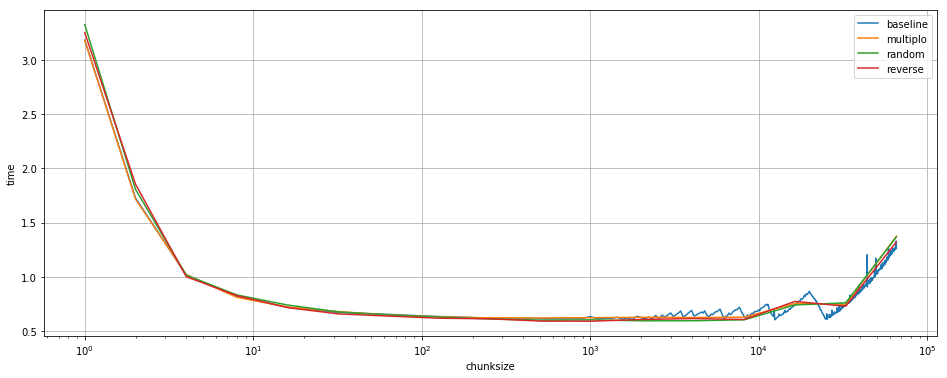

In [18]:
fig, ax = plt.subplots()
plt.plot(chunksizes_b, times_baseline)
ax.plot(chunksizes, times_multiplo)
ax.plot(chunksizes, times_random)
ax.plot(chunksizes, times_reverse)
ax.set_xscale('log')
ax.grid(True)
ax.set_xlabel('chunksize')
ax.set_ylabel('time')
ax.legend(['baseline', 'multiplo', 'random', 'reverse'])
fig.set_figwidth(16)
fig.set_figheight(6)

## Finding prime numbers (using queues)

A queue object allows us to implement interprocess communication using pickle files. This is useful to send objects with much state information. However, the elements in the queue are not persistent. Therefore, this may not be the best approach in case robustness is a requirement. Sending this data has an overhead since the data has to be pickled first, but this overhead has not a big impact in case of long jobs.

In this example we will check for prime numbers by processing a queue of candidate numbers and sending the detected prime numbers to another list. 

In [19]:
FLAG_ALL_DONE = b'WORK_FINISHED'
FLAG_WORKER_FINISHED_PROCESSING = b'WORKER_FINISHED_PROCESSING'

def check_prime(possible_primes_queue, definite_primes_queue, proc):
    while True:
        # This get function is a blocking function
        n = possible_primes_queue.get()
        if n == FLAG_ALL_DONE:
            definite_primes_queue.put(FLAG_WORKER_FINISHED_PROCESSING)
            break
        else:
            if n % 2 != 0:
                prime = True
                for i in np.arange(3, int(math.sqrt(n)) + 1, 2).tolist():
                    if n % i == 0:
                        prime = False
                        break
                if prime:
                    definite_primes_queue.put(n)

The Queue objects are created by means of a Manager object. These are sent to `multiprocessing` when forking processes, and the module takes charge of the synchronisation. Then we fill the first queue with the candidate prime numbers and trigger the processing:

In [20]:
primes = []

manager = Manager()
possible_primes_queue = manager.Queue()
definite_primes_queue = manager.Queue()

NBR_PROCESSES = 4
pool = Pool(processes = NBR_PROCESSES)
processes = []
for i in range(NBR_PROCESSES):
    p = Process(target = check_prime,
                                args = (possible_primes_queue,
                                        definite_primes_queue, i))
    processes.append(p)
    p.start()
    
t1 = time.time()
number_range = range(100000000, 101000000)

# add jobs to the inbound work queue
for possible_prime in number_range:
    possible_primes_queue.put(possible_prime)
    
# add poison pils to stop the remote workers
for n in range(NBR_PROCESSES):
    possible_primes_queue.put(FLAG_ALL_DONE)

And the following code processes the results from the workers:

In [21]:
processors_indicating_they_have_finished = 0
while True:
    new_result = definite_primes_queue.get() # Block while waiting for results
    if new_result == FLAG_WORKER_FINISHED_PROCESSING:
        processors_indicating_they_have_finished += 1
        if processors_indicating_they_have_finished == NBR_PROCESSES:
            break
    else:
        primes.append(new_result)
assert processors_indicating_they_have_finished == NBR_PROCESSES

print('Took: ' + str(time.time() - t1) + 's')
print(len(primes))
print(primes[:10])
print(primes[-10:])

Took: 100.86460709571838s
54208
[100000007, 100000037, 100000039, 100000049, 100000073, 100000081, 100000123, 100000127, 100000193, 100000213]
[100999889, 100999897, 100999901, 100999903, 100999919, 100999939, 100999949, 100999979, 100999981, 100999993]


In [22]:
pool.close()

Several aspects to take into account:

- This code is slower than using a single process without Queues. This is due to the communication overhead in comparation to the complexity of the task.
- We could use threads instead of processes so we could asynchronously start consuming results while the raw data is being feed into the workers. 

## Shared memory and locks

This code shows an example on how four processes can work together to increment the variable of a variable. This variable is shared among processes by using a Value object. Therefore, all the processes access the same bytes in memory when accessing this variable. To avoid missing updates we use a Lock object, so that no other process can update the variable if there is another process already doing so. 

In [23]:
def work(value, max_count, lock):
    for n in range(max_count):
        # This is faster than using `with lock:`
        lock.acquire()
        value.value += 1
        lock.release()

In [24]:
MAX_COUNT_PER_PROCESS = 1000
NBR_PROCESSES = 4

processes = []
lock = Lock()
value = Value('i', 0)
for process_nbr in range(NBR_PROCESSES):
    p = Process(target = work, args = (value, MAX_COUNT_PER_PROCESS, lock))
    p.start()
    processes.append(p)

In [25]:
value.value

948